# Data Scientist Assignment - Simple outlier detection

## Data Import & Basic Exploratory Data Analysis
The <a target="_blank" href="https://www.kaggle.com/c/avazu-ctr-prediction">data</a> is made available by Kaggle and consists of three files. I have imported the file **train.csv** which contais the field **click**, used to calculate the CTR. 

I have downloaded the file locally. Since the file contains more than 40 million rows, I have randomly sampled around 1% of the data to work locally with it - Furthermore I've selected only the columns used in this analysis: **'hour'** and **'click'**.

In [1]:
import pandas as pd
import random
f = "train.csv"
num_lines = sum(1 for l in open(f)) # number of rows in file
size = int(num_lines / 100) # sample size of ~ 1%
skip_idx = random.sample(range(1, num_lines), num_lines - size) # 0 is not included to keep the header!
# Read the data (only 'hour' and 'click' columns)
df = pd.read_csv(f, skiprows=skip_idx, usecols=['hour','click'])

In [2]:
df.shape

(404288, 2)

In [3]:
df.dtypes

click    int64
hour     int64
dtype: object

The remaining data has around ~400.000 rows. The column **'hour'** has integer type - I have converted it to datetime and stored the new column as **'hour_dt'** to facilitate the later manipulation. I have also dropped the original column.

In [4]:
hour_dt = df['hour'].apply(lambda x: pd.to_datetime(str(x), format='%y%m%d%H'))
df['hour_dt'] = hour_dt
df = df.drop('hour', axis=1)
df.head()

,click,hour_dt
0,0,2014-10-21
1,0,2014-10-21
2,0,2014-10-21
3,0,2014-10-21
4,0,2014-10-21


In [5]:
df.hour_dt.describe()

count                  404288
unique                    240
top       2014-10-22 10:00:00
freq                     4490
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour_dt, dtype: object

The training set contains 10 days (240 hours) of measurements.
* Start: 14102100 (00:00, 21.Oct,2014) 
* End: 14103023 (23:00, 30.Oct,2014) 

In [6]:
df['click'].value_counts()/len(df)

0    0.830378
1    0.169622
Name: click, dtype: float64

The overall CTR is approx. 17%, while approx. 83% of the impressions are not clicked.

## Task 1 - CTR over time
The first task is to aggregate data by “hour”, calculate CTR and plot the resulting time series. Firstly I ahve aggregated the values by hour - showing all the 240 hours of measurements, as stated above.

### a) Aggregation per hour - 10 days, 240 groups

I aggregate the clicks by hour returning both following values:
* clicks (only values with click = 1) 
* impressions (click = 0 or 1: all impressions). 

The CTR can be then calculated by **CTR = clicks / impressions**

In [7]:
df_grouped_hour = df.groupby('hour_dt')['click'].agg(['sum','count'])
df_grouped_hour.columns = ['clicks', 'impressions']
df_grouped_hour['CTR'] = df_grouped_hour['clicks'] / df_grouped_hour['impressions']
df_grouped_hour = df_grouped_hour.reset_index()
df_grouped_hour.head()

,hour_dt,clicks,impressions,CTR
0,2014-10-21 00:00:00,193,1174,0.164395
1,2014-10-21 01:00:00,244,1382,0.176556
2,2014-10-21 02:00:00,297,2050,0.144878
3,2014-10-21 03:00:00,320,1895,0.168865
4,2014-10-21 04:00:00,390,2599,0.150058


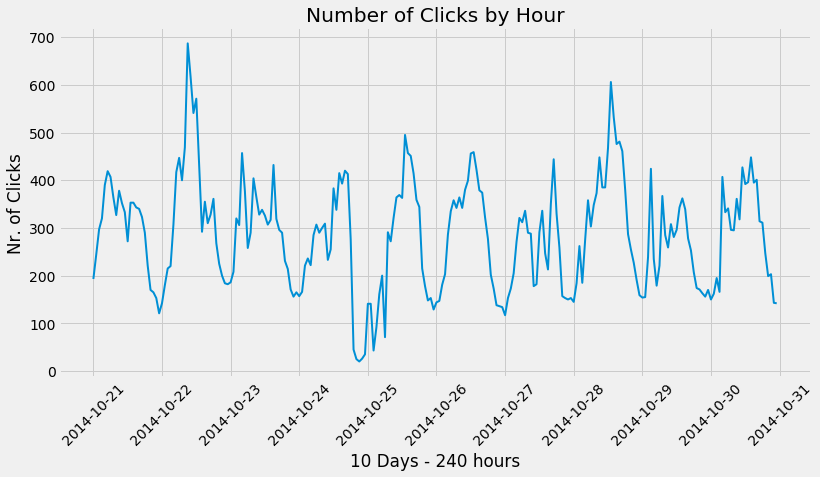

In [18]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('fivethirtyeight') #one of my favorite visualization styles :)
plt.figure(figsize=(12,6))
plt.plot(df_grouped_hour['hour_dt'],df_grouped_hour['clicks'], lw=2)
plt.ylabel('Nr. of Clicks')
plt.xlabel('10 Days - 240 hours')
plt.title('Number of Clicks by Hour')
plt.xticks(rotation=45) # easier to visualize
plt.show()

The plot shows that the click pattern is pretty similar everyday. There are some high peaks on the 22. and 28. of October and one valley late on 24. October.

### b) Aggregation per hour of day (click trends by hour of day), 24 groups
In this situation the aggregation is done hour-based - which means that all equal hours from different days are put together. For this task I have first created a new column containing only the hour of the day, which was easy to extracet from the datetime elements.

In [9]:
df['hour_of_day'] = df['hour_dt'].apply(lambda x: x.hour)

In [10]:
df_grouped_hour_24 = df.groupby('hour_of_day')['click'].agg(['sum','count'])
df_grouped_hour_24.columns = ['clicks', 'impressions']
df_grouped_hour_24['CTR'] = df_grouped_hour_24['clicks'] / df_grouped_hour_24['impressions']
df_grouped_hour_24 = df_grouped_hour_24.reset_index()
df_grouped_hour_24

,hour_of_day,clicks,impressions,CTR
0,0,1529,8377,0.182524
1,1,1740,9750,0.178462
2,2,2146,12430,0.172647
3,3,2357,13828,0.170451
4,4,3011,19115,0.157520
5,5,3224,19910,0.161929
6,6,3025,17668,0.171213
7,7,3324,18779,0.177006
8,8,3379,20852,0.162047
9,9,3758,22594,0.166327


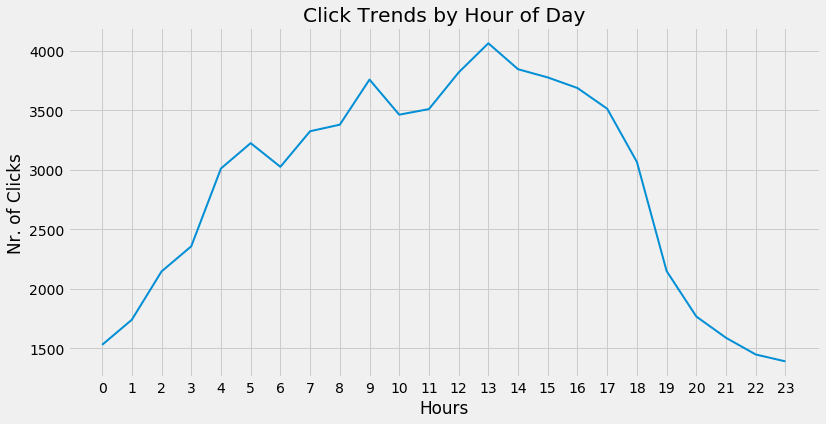

In [11]:
import numpy as np 

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,6))
plt.xticks(np.arange(0, 24))
plt.plot(df_grouped_hour_24['hour_of_day'],df_grouped_hour_24['clicks'], lw=2)
plt.ylabel('Nr. of Clicks')
plt.xlabel('Hours')
plt.title('Click Trends by Hour of Day')
plt.show()

The highest number of clicks occur around 13 (1 pm) and the lowest number of clicks is around hour 0 (mid-night). We can also check the behaviour of the CTR for the same aggregation - see below:

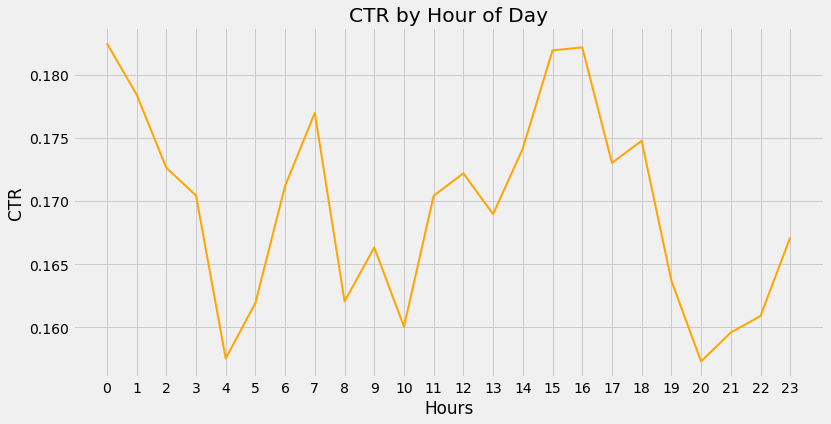

In [12]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,6))
plt.xticks(np.arange(0, 24))
plt.plot(df_grouped_hour_24['hour_of_day'],df_grouped_hour_24['CTR'], lw=2, color='orange')
plt.ylabel('CTR')
plt.xlabel('Hours')
plt.title('CTR by Hour of Day')
plt.show()

In this case it is around midnight where we find the highest CTRs. It is interesting that, even though the absolute click number is the lowest at this time, people seem to be more prone to click.

## Task 2 - Outlier Detection
The definition of this second task resembles the Bollinger Band analysis, which also considers a moving average and tolerance bands based on the standard deviation. For the Bollinger Band chart normally windows of 20 days are used and the bands are located at 2xstd. In our case we have the bands at 1.5 x std and we use a couple of hours for the windows.

For this analysis I have used **the df_grouped_hour** defined at Task 1a. A possible usage of **df_grouped_hour_24** is commented in the Conlusion.


### 2.1 SMA - Simple Moving Average (window = 3)
Firstly I have tried with window = 3 and a simple moving average, by using the **rolling** function from Pandas.

In [13]:
df_grouped_hour['SMA'] = df_grouped_hour['CTR'].rolling(window=3).mean()
df_grouped_hour['SSTD'] = df_grouped_hour['CTR'].rolling(window=3).std()  
df_grouped_hour['upper_limit'] = df_grouped_hour['SMA'] + (df_grouped_hour['SSTD'] * 1.5)
df_grouped_hour['lower_limit'] = df_grouped_hour['SMA'] - (df_grouped_hour['SSTD'] * 1.5)
df_grouped_hour.head(10)

,hour_dt,clicks,impressions,CTR,SMA,SSTD,upper_limit,lower_limit
0,2014-10-21 00:00:00,193,1174,0.164395,NaN,NaN,NaN,NaN
1,2014-10-21 01:00:00,244,1382,0.176556,NaN,NaN,NaN,NaN
2,2014-10-21 02:00:00,297,2050,0.144878,0.161943,0.015981,0.185914,0.137972
3,2014-10-21 03:00:00,320,1895,0.168865,0.163433,0.016523,0.188217,0.138649
4,2014-10-21 04:00:00,390,2599,0.150058,0.154600,0.012622,0.173534,0.135667
5,2014-10-21 05:00:00,419,2817,0.148740,0.155888,0.011258,0.172775,0.139000
6,2014-10-21 06:00:00,407,2522,0.161380,0.153392,0.006949,0.163815,0.142970
7,2014-10-21 07:00:00,364,2079,0.175084,0.161735,0.013176,0.181498,0.141971
8,2014-10-21 08:00:00,327,2015,0.162283,0.166249,0.007665,0.177746,0.154752
9,2014-10-21 09:00:00,378,2306,0.163920,0.167096,0.006966,0.177545,0.156646


In [14]:
def plot_outlier_detector(dataframe):
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot()

    x_axis = dataframe['hour_dt']
    # fill between upper & lower limits
    ax.fill_between(x_axis, dataframe['upper_limit'], dataframe['lower_limit'], color='lightgrey')

    # Plot CTR and Moving Averages
    col = np.where(dataframe['CTR'] < dataframe['lower_limit'],'r', np.where(dataframe['CTR'] > dataframe['upper_limit'],'r','b'))
    ax.plot(x_axis, dataframe['CTR'],color='blue',lw=1)
    ax.scatter(x_axis, dataframe['CTR'], marker='.', color=col, lw=1)
    ax.plot(x_axis, dataframe['SMA'], color='black', lw=2)

    #Custom Legend handle
    legend_elements = [Line2D([0], [0], color='blue', lw=1, label='CTR'),
                       Line2D([0], [0], color='black', lw=2, label='SMA'),
                       Line2D([0], [0], marker='.', color='b', lw=0, label='Outliers',
                              markerfacecolor='r', markersize=15, markeredgewidth=0),
                       Patch(facecolor='lightgrey',
                             label='Tolerance Area')]

    # set further params and show the plot
    ax.set_title('Outlier Detection for CTR with Tolerance Bands')
    ax.set_xlabel('Date (Day)')
    ax.set_ylabel('CTR')
    plt.xticks(rotation=45)
    ax.legend(handles = legend_elements, loc='upper right', ncol=2)
    plt.show();

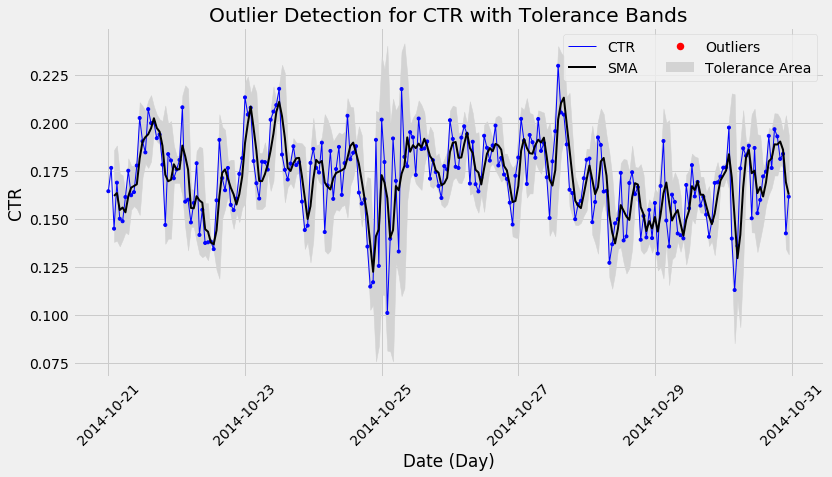

In [15]:
#call of plot function
plot_outlier_detector(df_grouped_hour)

In the plot above the grey area represents the tolerance area between the lower and upper limits.As we can see no outlier was detected - a window of 3 was able to capture well the pattern for our cyclical data. I have also tried with a window of 5 hours, which added more variance to the MA.  

### 2.2 SMA - Simple Moving Average (window = 5)

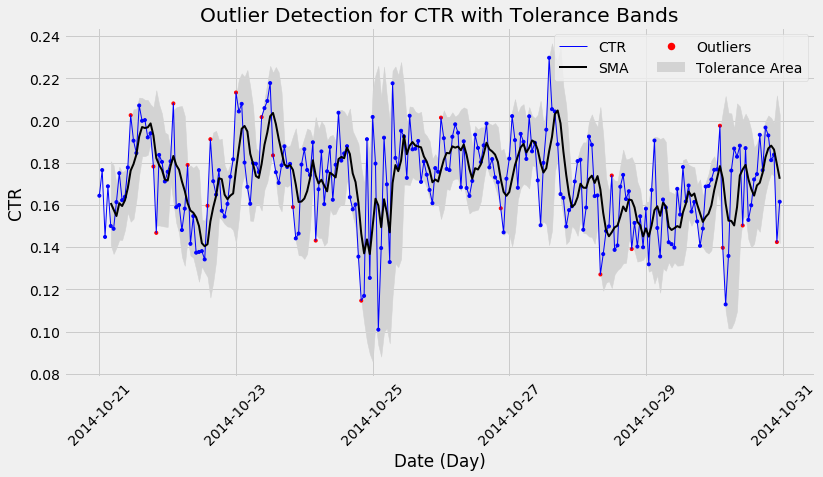

In [16]:
df_grouped_hour['SMA'] = df_grouped_hour['CTR'].rolling(window=5).mean()
df_grouped_hour['SSTD'] = df_grouped_hour['CTR'].rolling(window=5).std()  
df_grouped_hour['upper_limit'] = df_grouped_hour['SMA'] + (df_grouped_hour['SSTD'] * 1.5)
df_grouped_hour['lower_limit'] = df_grouped_hour['SMA'] - (df_grouped_hour['SSTD'] * 1.5)

plot_outlier_detector(df_grouped_hour)

In [17]:
lower_outliers = df_grouped_hour[df_grouped_hour['CTR'] < df_grouped_hour['lower_limit']]['CTR'].value_counts().sum()
upper_outliers = df_grouped_hour[df_grouped_hour['CTR'] > df_grouped_hour['upper_limit']]['CTR'].value_counts().sum()

print('Lower Outliers: {}, Higher Outliers: {}, Total: {}'.format(lower_outliers, upper_outliers, lower_outliers+upper_outliers)) 

Lower Outliers: 12, Higher Outliers: 10, Total: 22


Outliers are the red dots in the plot. For window=5, we have a total of 24 outliers, which is exactly 10% of the 240 (24h, 10 days) intervals analyzed.

## Conclusion and Possible Next Steps
In this task I have imported a sample of the underlying raw data into this notebook and performed some initial EDA, then I calculated the CTR on aggregated hour data and identified some periodicity of the values within the 10 available days.

When aggregating over daily hours,we find out that midnight concentrates the lowest absolute click values, but also the highest CTR, so it seems people are more prone to click at this time.

In the second part I built a simple outlier detection algorithm based on the idea behind the Bollinger Band statistical chart - an approach used frequently to analyse fluctuations in the financial/stock market. For this purpose I have used a Simple Moving Average with a 3 hours window, which did a pretty good job by capturing the pattern of the data - returning no outliers. 

By using a window of 5 hours the results were deteriorated by the daily periodical variance of data, leading to the appearance of some outliers - highlited in the plot. This simple analysis shows how important it is to select an appropriate window size for calculating the simple moving average and how it is sensitive to periodical/cyclical changes in data.

### SMA, CMA & EMA
One interesting thing to do would be to try different moving averages: e.g. Cumulative Moving Average (CMA) - which considers all values since the beginning for calculating the average, The CNA is, therefore, less sensitive to variations in data. Another method is the Exponential Moving Average (EMA), which places more weight on the most recent data points.

### MA hour-wise
Another interesting approach would be to take into accoung the cyclical nature of the CTR data and consider the hours of the day independently, as we performed in Task 1b. E.g. we take all values for hour = 3 in all 10 days and use these values for calculating the moving average, standard deviation and tolerance bands. In this case we would have 24 segmented analysis, but a much smaller variance. Especially in this case a Cumulative Moving Average weould be appropriate as we would have only 10 values to work with in each hour-group.

We could also consider weekday-weekends variations (which in this analysis is quite limited due to the presence of only 10 days of values)

## References
* <a target="_blank" href="https://matplotlib.org/">Matplotlib</a>
* <a target="_blank" href="https://www.datacamp.com/community/tutorials/moving-averages-in-pandas">DataCamp: Moving Averages in pandas</a>
* <a target="_blank" href="https://en.wikipedia.org/wiki/Bollinger_Bands">Bollinger Bands</a>
* <a target="_blank" href="https://towardsdatascience.com/anomaly-detection-def662294a4e">Anomaly Detection- Key Feature</a>
* <a target="_blank" href="https://medium.com/python-data/setting-up-a-bollinger-band-with-python-28941e2fa300">Setting up a Bollinger Band with Python</a>